In [86]:
# Importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
from PIL import Image

#from google.colab.patches import cv2_imshow

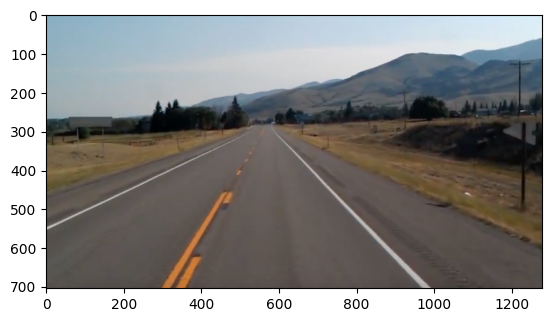

In [87]:
# Load test image and display it
image_colour = cv2.imread('../testsets/images/lane-detection-test.jpg')
plt.figure()
plt.imshow(cv2.cvtColor(image_colour, cv2.COLOR_BGR2RGB))

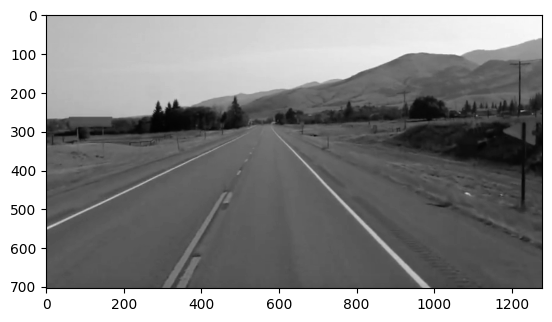

In [88]:
# Create a copy of the test image to transform and convert it to grayscale
laneline_image = np.copy(image_colour)
gray_image= cv2.cvtColor(laneline_image, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(gray_image, cmap='gray')

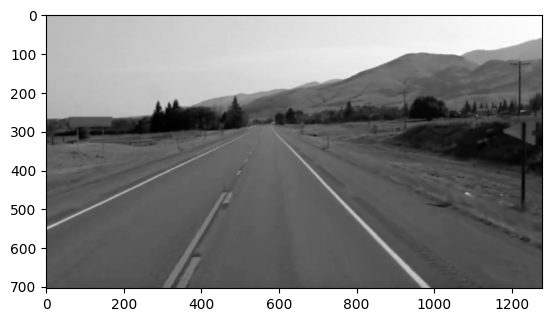

In [89]:
# Reduce the noise and smoothen the test image using Gaussian blur to detect the true edges and sharpness of the image
blurred_image = cv2.GaussianBlur(gray_image, (5,5),0)
plt.figure()
plt.imshow(blurred_image, cmap='gray')

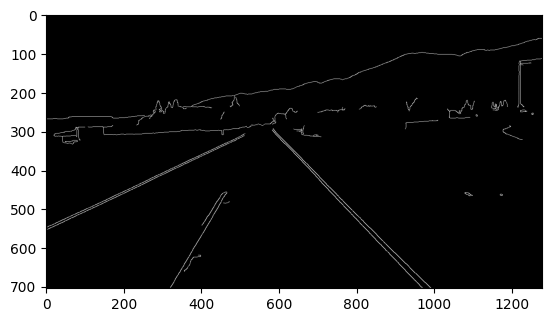

In [90]:
# Detect the edges in the test image using Canny edge detection algorithm and display the image
canny_edge_image = cv2.Canny(blurred_image, 50, 155)
plt.figure()
plt.imshow(canny_edge_image, cmap='gray')

The main goal of masking the regions of interest is to color filter an image to perform different operations.

In the autonomous car the region of interest for the car is the lane lines because it must be driven on the road

In [91]:
# Create a function to perform the above steps that we can call on any image or frame of a video
# Applies Canny edge detection algorithm to detect edges in an image.
def canny_edge_detection(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

    # Apply Gaussian blur to smooth the image and reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)  

    # Perform Canny edge detection with specified thresholds
    canny_edge_image = cv2.Canny(blurred_image, 50, 150)  
    return canny_edge_image  # Return the image with edges detected


In [92]:
# Define a region of interest mask where lane lines usually appear in the videos and images we use
# Adjusting the mask to the videos taken in Ali's Car
# For 1080p videos/images
def region_of_interest(image):
    # Get the height of the image to use for defining the polygon's vertices
    image_height = image.shape[0]  

    # Define the polygon for the mask
    polygons = np.array([[(200, image_height), (1100, image_height), (600, 250)]])  

    # Create a mask of zeros with the same dimensions as the image
    masked_image = np.zeros_like(image)  

    # Fill the defined polygon area with white (255) on the mask
    cv2.fillPoly(masked_image, polygons, 255)  

    return masked_image  # Return the masked image


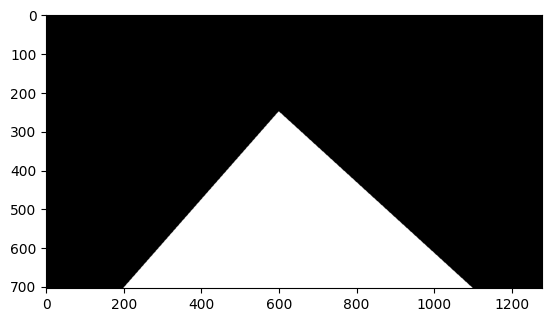

In [93]:
# Test the new function on the test image
canny_edge_image = canny_edge_detection(laneline_image)

# Output the masked test image
plt.figure()
plt.imshow(region_of_interest(canny_edge_image), cmap='gray')

we will multiply all the bits in the black region of the image by 0000 and white region by 1111

In [94]:
# Modify the mask function to multiply all the bits in the black region of the image by 0000 and white region by 1111 and use it on the test image
def region_of_interest(image):
  image_height = image.shape[0]
  polygons = np.array([[(200, image_height), (1100, image_height), (600,250)]])
  image_mask = np.zeros_like(image)
  cv2.fillPoly(image_mask, polygons, 255)
  masked_image = cv2.bitwise_and(image, image_mask)
  return masked_image

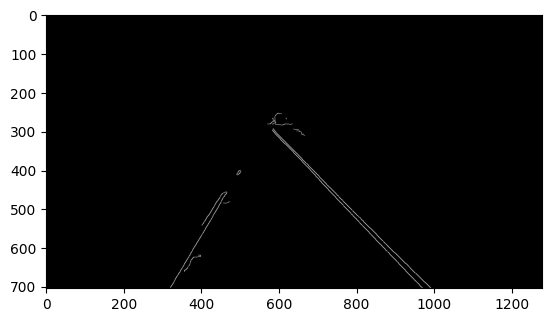

In [95]:
# Test the new function on the test image and display the cropped image
cropped_image = region_of_interest(canny_edge_image)
plt.figure()
plt.imshow(cropped_image, cmap='gray')  

In [96]:
# Create a function to show the lines on the test image
def show_lines(image, lines):
  lines_image = np.zeros_like(image)
  if lines is not None:
    for line in lines:
      X1,Y1,X2,Y2 = line.reshape(4)
      cv2.line(lines_image, (X1,Y1), (X2,Y2), (255,0,0),10)
  return lines_image

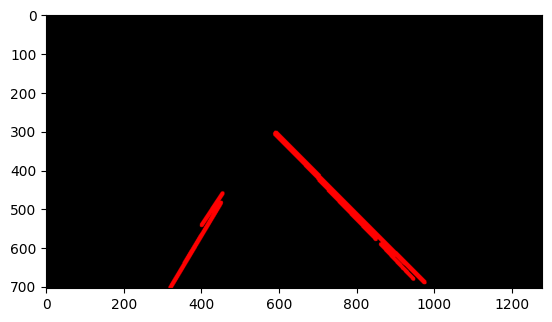

In [97]:
# Detect the lines in the test image using Hough transform and display the image with blue lines on the lane lines
lane_lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
linelines_image = show_lines(laneline_image, lane_lines)

plt.figure()
plt.imshow(linelines_image)


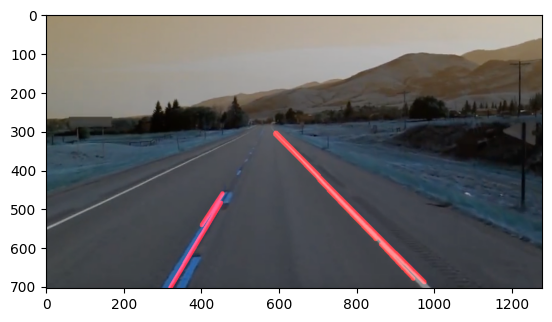

In [98]:
# Combine the new line overlay image with the original test image and display the final image
lane_image = show_lines(laneline_image, lane_lines)
combined_image = cv2.addWeighted(laneline_image, 0.8, lane_image, 1, 1)

plt.figure()
plt.imshow(combined_image)

In [99]:
# Function to calculate pixel coordinates for lines based on slope and intercept within an image.
def make_coordinates(image, line_parameters):
    # Unpack the slope and intercept from line parameters, which are averaged from the detected lines
    slope, intercept = line_parameters

    y1 = image.shape[0]  # Get the bottom of the image
    y2 = int(y1 * (3/5))  # Calculate 3/5 of the image height for the endpoint of the line
    x1 = int((y1 - intercept) / slope)  # Calculate x-coordinate for y1 using the line equation
    x2 = int((y2 - intercept) / slope)  # Calculate x-coordinate for y2 using the line equation
    
    return np.array([x1, y1, x2, y2])  # Return the coordinates as an array


In [100]:
#This function calculates the average slope and y-intercept for the lines detected in the image
def average_slope_intercept(image, lines):
    # Create lists to store the slope and intercept for lines on the left and right
    left_fit = []
    right_fit = [] 

    for line in lines:  # Iterating over each detected line
        # Reshape line coordinates into seprate variables
        x1, y1, x2, y2 = line.reshape(4)

        # Fit a line to the points, returning slope and intercept
        parameters = np.polyfit((x1, x2), (y1, y2), 1)

        # Extract the slope from parameters
        slope = parameters[0]  

         # Extract the intercept from parameters
        intercept = parameters[1]

        if slope < 0:  # If the slope is negative, it is part of the left side lines
            left_fit.append((slope, intercept))
        else:  # Otherwise, it's part of the right side lines
            right_fit.append((slope, intercept))

    # Calculate the average slope and intercept for left lines and right lines
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0) 

    # Calculate coordinates for the average left line and right line
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)

    # Return an array containing both lines
    return np.array([left_line, right_line])  


In [101]:
# Function to perform Canny edge detection to identify edges in an image.
def canny_edge_detection(image):
    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce image noise and detail  
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)  

    # Perform Canny edge detection with specified thresholds
    canny_edge_image = cv2.Canny(blurred_image, 50, 150)  

    # Return the image with edges detected
    return canny_edge_image  


In [102]:
# Function to draw the detected lines on a blank image with the same dimensions as the input image.
def show_lines(image, lines):
  # Initialize a blank image to draw lines on
    lines_image = np.zeros_like(image)
    
    if lines is not None:  # Check if any lines were detected
        for line in lines:
            X1, Y1, X2, Y2 = line.reshape(4)  # Extract endpoints of each line

            cv2.line(lines_image, (X1, Y1), (X2, Y2), (255, 0, 0), 10)  # Draw the line in red with a thickness of 10 pixels

    return lines_image  # Return the image with lines drawn


In [103]:
# Function to mask the image to isolate and focus on a specific triangular region of interest.
def region_of_interest(image):
    # Get the height of the image to help define the polygon vertices
    image_height = image.shape[0]  

     # Coordinates of the triangular polygon
    polygons = np.array([[(200, image_height), (1100, image_height), (550, 250)]]) 

    # Create an empty mask with the same dimensions as the image
    image_mask = np.zeros_like(image) 

    # Fill the polygon in the mask with white color
    cv2.fillPoly(image_mask, polygons, 255)

    # Apply the mask to the original image using a bitwise AND
    masked_image = cv2.bitwise_and(image, image_mask)  

    return masked_image  # Return the image with the region of interest isolated


In [104]:
# Copy the original color image to avoid modifying the original.
laneline_image = np.copy(image_colour)

# Apply Canny edge detection to the copied image to highlight edges.
canny_edge_image = canny_edge_detection(laneline_image)

# Crop the image to focus processing on regions likely to contain lane lines.
cropped_image = region_of_interest(canny_edge_image)

# Detect lines in the cropped image using the Hough Transform algorithm.
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

# Calculate the average slope and intercept for the detected lines to simplify the detection into clear lane lines.
averaged_lines = average_slope_intercept(laneline_image, lines)

# Create an image that overlays the calculated average lines on the original lane line image.
line_image = show_lines(laneline_image, averaged_lines)

# Combine the original lane line image with the line image using weighted sums for visual clarity.
combine_image = cv2.addWeighted(laneline_image, 0.8, line_image, 1, 1)

# Display the combined image using Matplotlib.
plt.figure()
plt.imshow(combined_image)

# Convert the image data to a PIL.Image object
# Note: PIL.Image.fromarray expects a numpy array, so make sure combine_image is a numpy array
pil_image = Image.fromarray(np.uint8(combined_image))
pil_image.save('C:\Users\Ali\OneDrive\Desktop\GitHub\automotive-cv\detection-outputs\images')


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1302123151.py, line 29)

**Detecting road markings on a video**

In [ ]:
# Function to convert line parameters (slope, intercept) into pixel coordinates on an image.
def make_coordinates(image, line_parameters):
    try:
        slope, intercept = line_parameters  # Unpack slope and intercept from the line parameters
    except TypeError:
        slope, intercept = 0.001, 0  # Default values for slope and intercept in case of a TypeError

    y1 = image.shape[0]  # Set y1 to the bottom of the image
    y2 = int(y1 * (3 / 5))  # Set y2 to 3/5 of the image height for consistent line height across the image
    x1 = int((y1 - intercept) / slope)  # Calculate x1 using the line equation y = mx + b
    x2 = int((y2 - intercept) / slope)  # Calculate x2 using the line equation y = mx + b

    return np.array([x1, y1, x2, y2])  # Return the calculated coordinates as an array


In [ ]:
# Function to calculate the average slope and intercept for left and right lines from a set of detected lines so that we can later output a much less jagged line.
def average_slope_intercept(image, lines):
    # Initialize list to store parameters (slope, intercept) of left lines and right lines
    left_fit = []  
    right_fit = [] 

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)  # Extract line endpoints
        parameter = np.polyfit((x1, x2), (y1, y2), 1)  # Fit a linear polynomial and get slope and intercept
        slope = parameter[0]  # Slope of the line
        intercept = parameter[1]  # Intercept of the line

        if slope < 0:  # Classify the line as a left line if the slope is negative
            left_fit.append((slope, intercept))
        else:  # Classify as a right line if the slope is positive
            right_fit.append((slope, intercept))

    # Calculate average slope and intercept for left lines and right lines
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0) 

    # Generate coordinates for the averaged left line and right line
    left_line = make_coordinates(image, left_fit_average)  
    right_line = make_coordinates(image, right_fit_average)

    return np.array([left_line, right_line])  # Return an array containing both average lines


In [ ]:
# Function to detect edges in an image using the Canny edge detection algorithm.
def canny_edge_detection(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)  

    # Perform Canny edge detection
    canny_edge_image = cv2.Canny(blurred_image, 50, 150)  
    
    return canny_edge_image  # Return the image with edges detected


In [ ]:

# Function to draw lines on an image
def show_lines(image, lines):
    line_image = np.zeros_like(image)  # Create a blank image with the same dimensions as the input image
    
    if lines is not None:  # Only proceed if lines are provided
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)  # Decompose the line into start and end coordinates
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)  # Draw the line in blue with a thickness of 10
    
    return line_image  # Return the image with drawn lines


In [ ]:
def region_of_interest(image):
    # Obtain the height of the image to help define the polygon region
    image_height = image.shape[0]

    # Define a polygon as the region of interest. Here, we specify the vertices of the polygon
    # This polygon covers a trapezoidal area typically used for lane detection in driving scenarios
    polygons = np.array([[(200, image_height), (1100, image_height), (550, 250)]])

    # Create an image mask of the same dimensions as our input image, initialized to black (all zeros)
    image_mask = np.zeros_like(image)

    # Fill the defined polygon with white (255) on the mask to specify where the image is to be kept
    cv2.fillPoly(image_mask, polygons, 255)

    # Apply the mask onto the original image to zero out pixels outside of the region of interest
    masking_image = cv2.bitwise_and(image, image_mask)

    # Return the image only where the mask has the region of interest defined
    return masking_image


In [ ]:
import cv2
import numpy as np
import time

# Open the video file
cap = cv2.VideoCapture("../testsets/videos/lane-detection-test.mp4")
if not cap.isOpened():
    print("Error opening video file")
    exit(1)

# Get the video frame width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object to write the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec definition
output_fps = 20.0  # Desired output frame rate
out = cv2.VideoWriter('../detection-outputs/videos/lane-detection.mp4', fourcc, output_fps, (frame_width, frame_height))

number_of_frames = 0

# Start timer to track execution time
start_time = time.time()

# Calculate the number of frames to skip to achieve the desired speed-up factor
speed_up_factor = 7
frame_skip = int(speed_up_factor)

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break  # Exit the loop if no frame is read

    # Skip frames based on the speed-up factor
    if number_of_frames % frame_skip != 0:
        number_of_frames += 1
        continue

    # Process frame
    # Apply Canny edge detection to extract edges from the frame.
    canny_edge_image = canny_edge_detection(frame)

    # Crop the edge-detected image to focus on the region of interest, primarily where lane lines would be located.
    cropped_canny_edge_image = region_of_interest(canny_edge_image)

    # Detect lines in the cropped image using the Hough Transform technique with specified parameters.
    lines = cv2.HoughLinesP(cropped_canny_edge_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

    # Calculate average slopes and intercepts to simplify multiple detected lines into a single line per lane side.
    averaged_lines = average_slope_intercept(frame, lines)

    # Draw these averaged lines on the original frame to visualize the lane lines.
    line_image = show_lines(frame, averaged_lines)

    # Combine the original frame with the line visualization, blending them to highlight the lines while retaining the original image visibility.
    combined_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)

    # Write the processed frame to the video file
    out.write(combined_image)

    number_of_frames += 1  # Increment the number of frames processed

# Release everything when job is finished
cap.release()
out.release()  # Close the file

# End timer and calculate execution time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time and the average time per frame
print(f"Execution time: {execution_time} seconds")
if number_of_frames > 0:
    print(f"Average time per frame: {execution_time / number_of_frames} seconds")
else:
    print("No frames processed.")



c:\Users\Ali\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Ali\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Execution time: 4.741767168045044 seconds
Average time per frame: 0.003661596268760652 seconds


ALI